# Supervised linear regression machine learning model to predict the primary dendritic arm spacing

# Project Overview

During the solidification of metallic systems, the microstructure grows in treelike dendritic shape and the morphology of dendrites has a strong effect on the mechanical properties. Spacing between the dendrite arms provides information on segregation patterns and distribution of precipitates between the dendritic arms, which influences the mechanical properties. There are two well-known theoretical models that relate the primary dendritic arm spacing (PDAS) to solidification conditions, namely pulling velocity (V) and temperature gradient (G), and material properties like liquid diffusivity (D_l), the freezing range (ΔT_0), Gibbs‐Thomson coefficient (Γ), and equilibrium partition coefficient (k_e). The two models, named Hunt-Burden (HB) [1] and Kurz-Fisher (KF) [2], are different in the way the material properties are accounted:

 PDAS=2.83(k_e ΓΔT_0 D_l )^0.25 G^(-0.5) V^(-0.25)  		HB model 
 
PDAS=4.3(ΓΔT_0 D_l/k_e )^0.25 G^(-0.5) V^(-0.25)	.	KF model

Despite the previous attempts, there are still important issues to develop a predictive model of PDAS for a wide range of solidification rates. In rapid solidification cases, such as in laser additive manufacturing of materials, the analytical relations and models for PDAS have significant deviations from computational predications and experimental data for the same solidification condition [3]. In this project we want to develop more reliable analytical models for prediction of PDAS in a wide range of solidification rates. For this, a supervised linear regression machine learning model will be used to produce a new relation between PDAS and the solidification rate (pulling velocity and temperature gradient in the model) that works for different material systems. 


# Data Wrangling

### 1. Sourcing and loading

#### 1a. Import relevant libraries 

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
import seaborn as sns # For all our visualization needs.
import statsmodels.api as sm # Second library for linear regression model based on OLS
from statsmodels.graphics.api import abline_plot # What does this do? Find out and type here.
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # acess performance.
from sklearn.model_selection import train_test_split,cross_validate,KFold,cross_val_score #split data in training and testing dataset
from sklearn import linear_model, preprocessing # linear regression models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
from sklearn import *

#### 1b. Load the data

We have generated the data, so we know they are almost clean. However, I perfowm the typical data wrangling steps use dto idensify if there are any problems with the data files

In [2]:
# Load the data. 
df=pd.read_csv("../Data/PDAS_all.csv")
df_exp=pd.read_csv("../Data/PDAS-experiment.csv")

#### 1c. Exploring the data

In [3]:
# Check out its appearance. 
df.head(n=5)

,V,G,Mat_HB,Mat_KF,PDAS
0,0.01,10000000.0,2.020000e-14,2.570000e-13,2.468570e-06
1,0.02,10000000.0,2.020000e-14,2.570000e-13,2.160000e-06
2,0.03,10000000.0,2.020000e-14,2.570000e-13,1.080000e-06
3,0.04,10000000.0,2.020000e-14,2.570000e-13,9.257140e-07
4,0.05,10000000.0,2.020000e-14,2.570000e-13,8.100000e-07


In [4]:
# overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V       250 non-null    float64
 1   G       250 non-null    float64
 2   Mat_HB  250 non-null    float64
 3   Mat_KF  250 non-null    float64
 4   PDAS    250 non-null    float64
dtypes: float64(5)
memory usage: 9.9 KB


Because I have already generated the data I know the data are all in correct format and all the rows have correct values.
However this shows all columns have correct data type. They also do not have a missing value

In [5]:
df.isna().any()

V         False
G         False
Mat_HB    False
Mat_KF    False
PDAS      False
dtype: bool

In [6]:
df_exp.isna().any()

V         False
G         False
Mat_HB    False
Mat_KF    False
PDAS      False
Alloy     False
dtype: bool

As expected, we do not have any NULL values

In [7]:
df.duplicated().any()

False

In [8]:
df['Mat_HB'].nunique()

7

The data set have overall data for 7 alloys. for each alloy the PDAS is calculated based on different values of V and G.

In [9]:
print(df["Mat_HB"].unique())

[2.02e-14 3.37e-14 3.51e-14 5.85e-15 2.30e-15 4.33e-15 5.11e-15]


In [10]:
# We need a new column showing the alloy name
# we know Mat_HB of 2.02e-14 3.37e-14 3.51e-14 5.85e-15 2.30e-15 4.33e-15 5.11e-15 belonds to Ti-3.4%Ni, Ti-7.1%Ni, Ti-10.6%Ni, 
# Mg-9 at% Al, Al-6 at%Cu, Al-8 at%Cu, and Al-10 at%Cu

conditions=[np.logical_and(df["Mat_HB"].gt(2.01e-14),df["Mat_HB"].lt(2.03e-14)),
            np.logical_and(df["Mat_HB"].gt(3.36e-14),df["Mat_HB"].lt(3.38e-14)),
            np.logical_and(df["Mat_HB"].gt(3.50e-14),df["Mat_HB"].lt(3.52e-14)),
            np.logical_and(df["Mat_HB"].gt(5.84e-15),df["Mat_HB"].lt(5.86e-15)),
            np.logical_and(df["Mat_HB"].gt(2.29e-15),df["Mat_HB"].lt(2.31e-15)),
            np.logical_and(df["Mat_HB"].gt(4.32e-15),df["Mat_HB"].lt(4.34e-15)),
            np.logical_and(df["Mat_HB"].gt(5.10e-15),df["Mat_HB"].lt(5.12e-15))]
outputs=["Ti-3.4 at% Ni","Ti-7.1 at% Ni","Ti-10.7 at% Ni","Mg- 9 at% Al","Al-6 at% Cu","Al-8 at% Cu","Al-10 at% Cu"]
df["Alloy"]=pd.Series(np.select(conditions,outputs,"alloy"))


In [11]:
# OUR equation will have the following format PDAS=A (V)^alpha (G)^beta (matprop)^gamma. To make this easier to change to
# a regression model, 
# we will first deside the dependent variable as PDAS and then We will take ln of all the columns and add it to a new column
#and move forward with that
df.head()

,V,G,Mat_HB,Mat_KF,PDAS,Alloy
0,0.01,10000000.0,2.020000e-14,2.570000e-13,2.468570e-06,Ti-3.4 at% Ni
1,0.02,10000000.0,2.020000e-14,2.570000e-13,2.160000e-06,Ti-3.4 at% Ni
2,0.03,10000000.0,2.020000e-14,2.570000e-13,1.080000e-06,Ti-3.4 at% Ni
3,0.04,10000000.0,2.020000e-14,2.570000e-13,9.257140e-07,Ti-3.4 at% Ni
4,0.05,10000000.0,2.020000e-14,2.570000e-13,8.100000e-07,Ti-3.4 at% Ni


In [12]:
# Get a basic statistical summary of the dependent variable 
#PDAS is our fixed dependent variable
df["PDAS"].describe()

count    2.500000e+02
mean     2.573232e-06
std      6.532639e-06
min      1.322670e-07
25%      4.926000e-07
50%      8.134800e-07
75%      1.470000e-06
max      6.294750e-05
Name: PDAS, dtype: float64

# Exploratory Data Analysis and Feature Engineering

Now that we've chosen PDAS as our dependent variable for regression analysis, we can begin by plotting the pairwise relationships in the dataset, to check out how our variables relate to one another.
if we plot the pairwise relationshi for V,G,matprop_HB,matprop_KF we do not see any specific relationship, but plotting the logaritmic in base e it will have useful information

In [13]:
# We do not have any missing or NA data points or any outliers. However, We have discussed in the summary that in order to use 
# the linear regression model we should modify our variables and use their logarithmic values in the ML model

df["PDAS_ln"]=np.log(df["PDAS"])
df["V_ln"]=np.log(df["V"])
df["G_ln"]=np.log(df["G"])
df["Mat_HB_ln"]=np.log(df["Mat_HB"])
df["Mat_KF_ln"]=np.log(df["Mat_KF"])
df_ln=df.drop(["PDAS","V","G","Mat_HB","Mat_KF"],axis=1)

In [14]:
# Call the .corr() method on the wine dataset 
df_ln.corr(method='pearson')

,PDAS_ln,V_ln,G_ln,Mat_HB_ln,Mat_KF_ln
PDAS_ln,1.000000,-0.817739,-0.180500,0.502430,0.411290
V_ln,-0.817739,1.000000,-0.042756,-0.133750,-0.087158
G_ln,-0.180500,-0.042756,1.000000,0.098657,0.242190
Mat_HB_ln,0.502430,-0.133750,0.098657,1.000000,0.962904
Mat_KF_ln,0.411290,-0.087158,0.242190,0.962904,1.000000


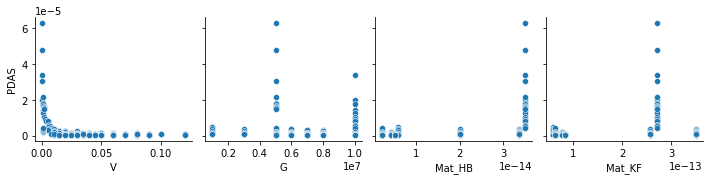

In [15]:
# Make a pairplot of the data just for PDAS
sns.pairplot(df,y_vars=["PDAS"],x_vars=["V","G","Mat_HB","Mat_KF"])

Visualization in this section helped us make sure we do not have any outliers in the PDAS data. However as said previously we need to checl the logaraithmic form of PDAS.
The results do not present a specific trend in for G , mat_HB, mat_Kf in comparison with the 

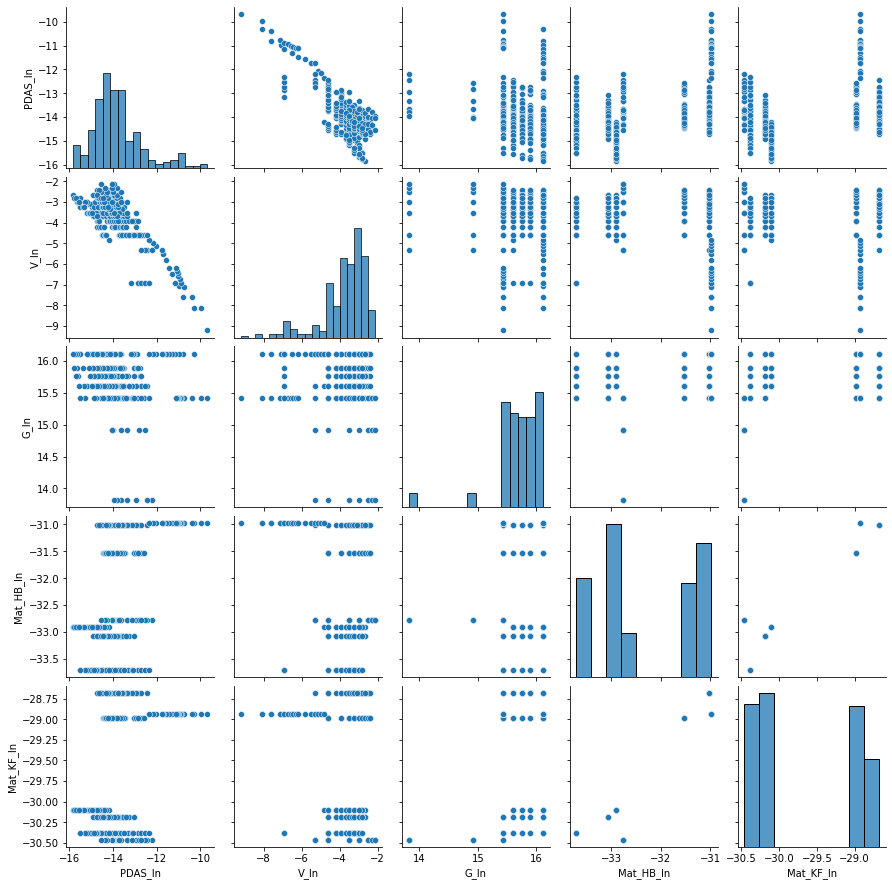

In [16]:
# Make a pairplot of the data
#sns.pairplot(df)
sns.pairplot(df_ln)

So we now have called the .corr() method, and the .pairplot() Seaborn method, on our data. Both have flaws. Happily, we can get the best of both worlds with a heatmap. 

<AxesSubplot:>

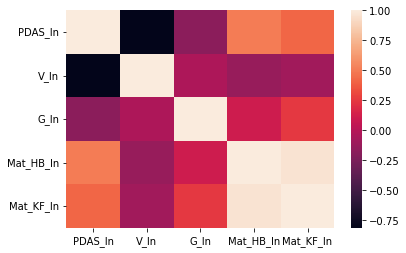

In [17]:
# Make a heatmap of the data 
sns.heatmap(df_ln.corr())

We find a strong correlation (negative) between PDAS_ln and V_ln, also PDAS_ln and G_ln. both HB and KF material properties also have strong but positive effects on PDAS_ln

In [18]:
color=sns.color_palette("husl", 7).as_hex()
print(color[0])

#f77189


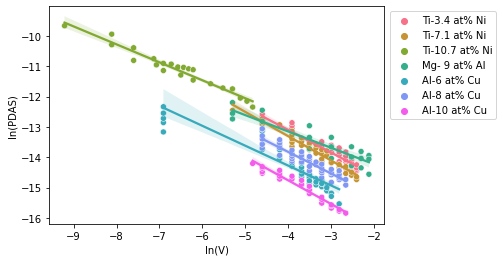

In [19]:
sns.scatterplot(data=df_ln,x="V_ln",y="PDAS_ln",hue="Alloy",palette=sns.color_palette("husl", 7)) #sizes=(20, 100),size="Mat_KF_ln",
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[0]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[0]}) #,line_kws={"color":"red"}
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[1]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[1]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[2]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[2]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[3]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[3]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[4]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[4]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[5]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[5]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[6]],x="V_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[6]})
plt.xlabel("ln(V)")
plt.ylabel("ln(PDAS)")
plt.legend(bbox_to_anchor=(1.35 , 1), loc="upper right")

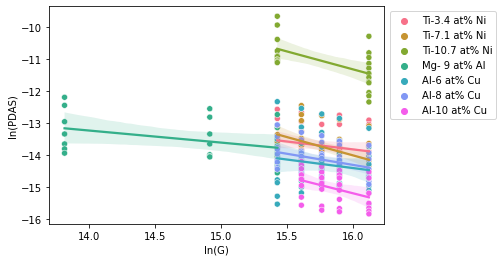

In [20]:
sns.scatterplot(data=df_ln,x="G_ln",y="PDAS_ln",hue="Alloy",palette=sns.color_palette("husl", 7)) #sizes=(20, 100),size="Mat_KF_ln",
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[0]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[0]}) #,line_kws={"color":"red"}
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[1]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[1]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[2]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[2]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[3]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[3]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[4]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[4]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[5]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[5]})
sns.regplot(data=df_ln[df_ln["Alloy"]==outputs[6]],x="G_ln",y="PDAS_ln", scatter=False,line_kws={"color":color[6]})
plt.xlabel("ln(G)")
plt.ylabel("ln(PDAS)")
plt.legend(bbox_to_anchor=(1.35 , 1), loc="upper right")

This shows we obtain a decending behavior between PDAS with both V and G , while it seems V have a stronger effect. This was also supported by the heatmap plot.

# Modeling 

## 3a. Making a Linear Regression mode based on all the data and HB model
### statmodels library 
First we will work on regression  model based on matprop_HP

In [21]:
# This will hold A, alpha, beta, gamma and their std (PDAS=A (V)^alpha (G)^beta (matprop)^gamma) and their standard deviations
#the order of columns is HB, KF, "Ti-3.4 at% Ni","Ti-7.1 at% Ni","Ti-10.7 at% Ni","Mg- 9 at% Al","Al-6 at% Cu","Al-8 at% Cu","Al-10 at% Cu"
all_coefficients=np.zeros((9,8))
all_outputs=["All (HB model)", "All (KF model)"]+outputs

In [22]:
# Create test and train datasets
# Include all columns from df_ln in the explanatory variables X except "PDAS_ln","Mat_KF_ln"
x=df_ln.drop(["PDAS_ln","Mat_KF_ln","Alloy"],axis=1)

# Create constants for X, so the model knows its bounds
x=sm.add_constant(x)
y=df[["PDAS_ln"]]

# Split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In [23]:
# We can use almost identical code to create the third model, because it is the same algorithm, just different inputs
# Create the model
rModel_HB= sm.OLS(y_train,x_train)

# Fit the model
results_HB = rModel_HB.fit()

In [24]:
# Evaluate the model
results_HB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PDAS_ln   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     538.7
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           1.54e-90
Time:                        21:40:38   Log-Likelihood:                -70.753
No. Observations:                 187   AIC:                             149.5
Df Residuals:                     183   BIC:                             162.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8604      1.348      5.833      0.000       5.202      10.519
V_ln          -0.6910      0.021    -33.028      0.000      -0.732      -0.650
G_ln          -0.6257      0.061    -10.331      0.000      -0.745      -0.506
Mat_HB_ln      0.4478      0.026     17.521      0.000       0.397       0.498
==============================================================================
Omnibus:                       16.672   Durbin-Watson:                   2.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.825
Skew:                          -0.773   Prob(JB):                     8.17e-05
Kurtosis:                       3.156   Cond. No.                     1.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# Use our new model to make predictions
pedictions_HB=results_HB.predict(x_test)

<Figure size 576x576 with 0 Axes>

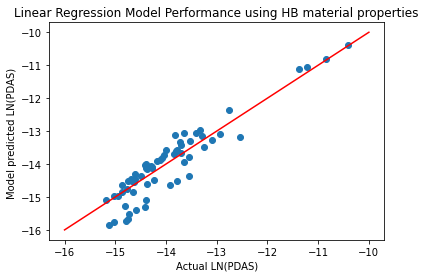

<Figure size 576x576 with 0 Axes>

In [26]:
# Plot the predictions
# Build a scatterplot
plt.scatter(pedictions_HB,y_test)
# Add a line for perfect correlation
plt.plot([-16,-10],[-16,-10],marker="None",color="red")

# Label it nicely
plt.xlabel("Actual LN(PDAS)")
plt.ylabel ("Model predicted LN(PDAS) ")
plt.title ("Linear Regression Model Performance using HB material properties")
#plt.xlim([4,16])
#plt.ylim([4,16])

plt.figure(figsize=(8, 8))

In [27]:
RMSE_HB=mean_squared_error(y_test,pedictions_HB,squared="yes")
print(RMSE_HB)

0.1765573509773601


## sklearn library and cross validation

In [28]:
#R2 for one split does not represent the model's accuracy. For this, we will perform KFold cross validation

# we will perform 20 kfold with 10 splits
x=df_ln.drop(["PDAS_ln","Mat_KF_ln","Alloy"],axis=1)
y=df_ln[["PDAS_ln"]]

num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
rModel_HB= linear_model.LinearRegression()
cv_result_HB=cross_validate(rModel_HB,x,y,cv=kf,return_estimator=True)
coeff=np.zeros((num_split,4))
i=0
for model in cv_result_HB['estimator']:
    coeff[i,0]=model.intercept_[0]
    coeff[i,1]=model.coef_[0,0]
    coeff[i,2]=model.coef_[0,1]
    coeff[i,3]=model.coef_[0,2]
    i+=1
#    print(model.coef_)
#    print(model.intercept_)

print("the mean ln(intercept) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,0]),np.std(coeff[:,0]),np.quantile(coeff[:,0],[0.025,0.975])))
print("the mean ln(V) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,1]),np.std(coeff[:,1]),np.quantile(coeff[:,1],[0.025,0.975])))
print("the mean ln(G) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,2]),np.std(coeff[:,2]),np.quantile(coeff[:,2],[0.025,0.975])))
print("the mean ln(matprop_HB) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,3]),np.std(coeff[:,3]),np.quantile(coeff[:,3],[0.025,0.975])))
cv_results_HB = cross_val_score(rModel_HB, x,y, cv=kf)
print("the mean r2 coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(cv_results_HB),np.std(cv_results_HB),np.quantile(cv_results_HB,[0.025,0.975])))


the mean ln(intercept) coeff is 8.987995792551175, with stdev of 0.19075500830129688 and 95%CI of [8.77254814 9.34138054]
the mean ln(V) coeff is -0.698693884311969, with stdev of 0.006363557823170287 and 95%CI of [-0.71192175 -0.69064017]
the mean ln(G) coeff is -0.6764139906069513, with stdev of 0.011152433596953441 and 95%CI of [-0.69138545 -0.6562787 ]
the mean ln(matprop_HB) coeff is 0.45917969233609346, with stdev of 0.004294376195423205 and 95%CI of [0.45179804 0.46409046]
the mean r2 coeff is 0.8698804782979483, with stdev of 0.036155282898044885 and 95%CI of [0.81149198 0.92566983]


In [29]:
# all_coefficients[0,:] summarizes the HB model
all_coefficients[0,0]=math.exp(np.mean(coeff[:,0]))
all_coefficients[0,1]=math.exp(np.mean(coeff[:,0])+np.std(coeff[:,0]))-math.exp(np.mean(coeff[:,0]))
all_coefficients[0,2]=np.mean(coeff[:,1])
all_coefficients[0,3]=np.std(coeff[:,1])
all_coefficients[0,4]=np.mean(coeff[:,2])
all_coefficients[0,5]=np.std(coeff[:,2])
all_coefficients[0,6]=np.mean(coeff[:,3])
all_coefficients[0,7]=np.std(coeff[:,3])
#print(all_coefficients)

## 3b. Making a Linear Regression mode based on all the data and KF model
First we will work on regression  model based on matprop_KF

## statmodels library

In [30]:
# Create test and train datasets
# Include all columns from df_ln in the explanatory variables X except "PDAS_ln","Mat_HB_ln"
x=df_ln.drop(["PDAS_ln","Mat_HB_ln", "Alloy"],axis=1)

# Create constants for X, so the model knows its bounds
x=sm.add_constant(x)
y=df[["PDAS_ln"]]

# Split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In [31]:
# We can use almost identical code to create the third model, because it is the same algorithm, just different inputs
# Create the model
rModel_KF= sm.OLS(y_train,x_train)

# Fit the model
results_KF = rModel_KF.fit()

In [32]:
# Evaluate the model
results_KF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PDAS_ln   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     516.5
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           4.85e-89
Time:                        21:41:49   Log-Likelihood:                -86.296
No. Observations:                 187   AIC:                             180.6
Df Residuals:                     183   BIC:                             193.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.2989      1.825      9.479      0.000      13.698      20.900
V_ln          -0.7226      0.022    -33.274      0.000      -0.765      -0.680
G_ln          -0.8075      0.071    -11.370      0.000      -0.948      -0.667
Mat_KF_ln      0.7151      0.042     17.172      0.000       0.633       0.797
==============================================================================
Omnibus:                       11.086   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                8.015
Skew:                          -0.388   Prob(JB):                       0.0182
Kurtosis:                       2.347   Cond. No.                     2.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# Use our new model to make predictions
pedictions_KF=results_KF.predict(x_test)

<Figure size 576x576 with 0 Axes>

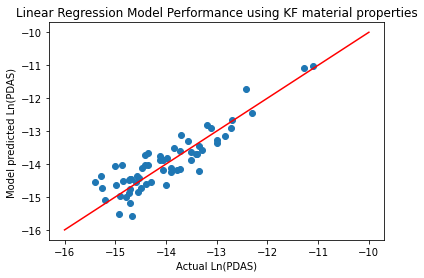

<Figure size 576x576 with 0 Axes>

In [34]:
# Plot the predictions
# Build a scatterplot
plt.scatter(pedictions_KF,y_test)
# Add a line for perfect correlation
plt.plot([-16,-10],[-16,-10],marker="None",color="red")

# Label it nicely
plt.xlabel("Actual Ln(PDAS)")
plt.ylabel ("Model predicted Ln(PDAS) ")
plt.title ("Linear Regression Model Performance using KF material properties")


#plt.xlim([4,16])
#plt.ylim([4,16])

plt.figure(figsize=(8, 8))

In [37]:
RMSE_KF=mean_squared_error(y_test,pedictions_KF,squared="yes")
print(RMSE_KF)

0.1736643440746365


## sklearn library and cross validation

In [38]:
#R2 for one split does not represent the model's accuracy. For this, we will perform KFold cross validation

# we will perform 20 kfold with 10 splits
x=df_ln.drop(["PDAS_ln","Mat_HB_ln","Alloy"],axis=1)
y=df_ln[["PDAS_ln"]]

num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
rModel_KF= linear_model.LinearRegression()
cv_result_KF=cross_validate(rModel_KF,x,y,cv=kf,return_estimator=True)
coeff=np.zeros((num_split,4))
i=0
for model in cv_result_KF['estimator']:
    coeff[i,0]=model.intercept_[0]
    coeff[i,1]=model.coef_[0,0]
    coeff[i,2]=model.coef_[0,1]
    coeff[i,3]=model.coef_[0,2]
    i+=1
#    print(model.coef_)
#    print(model.intercept_)

print("the mean ln(intercept) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,0]),np.std(coeff[:,0]),np.quantile(coeff[:,0],[0.025,0.975])))
print("the mean ln(V) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,1]),np.std(coeff[:,1]),np.quantile(coeff[:,1],[0.025,0.975])))
print("the mean ln(G) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,2]),np.std(coeff[:,2]),np.quantile(coeff[:,2],[0.025,0.975])))
print("the mean ln(matprop_KF) coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(coeff[:,3]),np.std(coeff[:,3]),np.quantile(coeff[:,3],[0.025,0.975])))
cv_results_KF = cross_val_score(rModel_KF, x,y, cv=kf)
print("the mean r2 coeff is {}, with stdev of {} and 95%CI of {}".format(np.mean(cv_results_KF),np.std(cv_results_KF),np.quantile(cv_results_KF,[0.025,0.975])))


the mean ln(intercept) coeff is 15.992262920940027, with stdev of 0.29847052432540083 and 95%CI of [15.46893755 16.41126612]
the mean ln(V) coeff is -0.7193281970373033, with stdev of 0.006741737783767865 and 95%CI of [-0.73288942 -0.71043531]
the mean ln(G) coeff is -0.8363273763167743, with stdev of 0.01200724104214886 and 95%CI of [-0.85149264 -0.81985497]
the mean ln(matprop_KF) coeff is 0.6549375524292186, with stdev of 0.007404270479879986 and 95%CI of [0.64246812 0.6619441 ]
the mean r2 coeff is 0.8546594255268145, with stdev of 0.043952778383985674 and 95%CI of [0.7767437  0.91385899]


In [39]:
# all_coefficients[1,:] summarizes the KF model
all_coefficients[1,0]=math.exp(np.mean(coeff[:,0]))
all_coefficients[1,1]=math.exp(np.mean(coeff[:,0])+np.std(coeff[:,0]))-math.exp(np.mean(coeff[:,0]))
all_coefficients[1,2]=np.mean(coeff[:,1])
all_coefficients[1,3]=np.std(coeff[:,1])
all_coefficients[1,4]=np.mean(coeff[:,2])
all_coefficients[1,5]=np.std(coeff[:,2])
all_coefficients[1,6]=np.mean(coeff[:,3])
all_coefficients[1,7]=np.std(coeff[:,3])
#print(all_coefficients)

## 3c. Different Parametrized and Nonparametrized ML regression Models based on KF Material Properties


In [40]:
# Create test and train datasets
# Include all columns from df_ln in the explanatory variables X except "PDAS_ln","Mat_HB_ln"
x=df_ln.drop(["PDAS_ln","Mat_HB_ln", "Alloy"],axis=1)

# Create constants for X, so the model knows its bounds
x=sm.add_constant(x)
y=df[["PDAS_ln"]]

# Split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

In [41]:
def spotcheck(X_train,X_test,y_train, y_test):
  models =[("LinearR", linear_model.LinearRegression()),
          ("DTR", DecisionTreeRegressor()),  
          ('RF',RandomForestRegressor()),
          ('KNN', KNeighborsRegressor(n_neighbors=10)), 
          ("SVR", SVR()),
          ("SGDR", linear_model.SGDRegressor()),
          ("Ridge", linear_model.RidgeCV()),          
          ('ADA', AdaBoostRegressor()),
          ('XGB',GradientBoostingRegressor()),
          ('PAC',linear_model.PassiveAggressiveRegressor())]

  results = []
  names = []
  finalResults = []

  for name,model in models:
      model.fit(X_train, y_train.values.ravel())
      model_results = model.predict(X_test)
      r2score = r2_score(y_test, model_results) 
      MSE = mean_squared_error(y_test, model_results)
      MAE = mean_absolute_error(y_test, model_results)
      results.append(r2score)
      results.append(MSE)
      results.append(MAE)
      names.append(name)
      finalResults.append((name, r2score, MSE, MAE))
      
  finalResults.sort(key=lambda k:k[1],reverse=True)
  return finalResults

In [42]:
proofstress_df = pd.DataFrame(spotcheck(x_train,x_test,y_train, y_test), columns=['Model Name', 'R2 Score', 'MSE', 'MAE'])
proofstress_df

,Model Name,R2 Score,MSE,MAE
0,DTR,9.856975e-01,1.860932e-02,1.061320e-01
1,XGB,9.840703e-01,2.072655e-02,1.017001e-01
2,RF,9.839795e-01,2.084464e-02,1.061333e-01
3,ADA,9.019133e-01,1.276229e-01,3.107960e-01
4,KNN,8.791151e-01,1.572862e-01,3.051367e-01
5,LinearR,8.702553e-01,1.688139e-01,3.357041e-01
6,Ridge,8.702272e-01,1.688504e-01,3.357659e-01
7,PAC,8.245575e-01,2.282724e-01,3.585210e-01
8,SVR,3.125555e-01,8.944501e-01,6.617092e-01
9,SGDR,-9.209404e+14,1.198257e+15,2.818844e+07


## Optimize decision tree branching

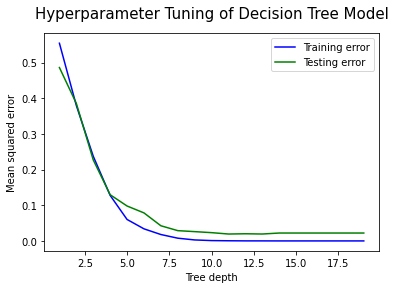

In [43]:
max_depths = range(1, 20)
training_error = []
testing_error = []
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth)
    model_1.fit(x_train, y_train)
    training_error.append(mean_squared_error(y_train, model_1.predict(x_train)))
    testing_error.append(mean_squared_error(y_test, model_1.predict(x_test)))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')

plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of Decision Tree Model', pad=15, size=15)
plt.legend()

## Optimize decision tree branching using cross validation

No handles with labels found to put in legend.


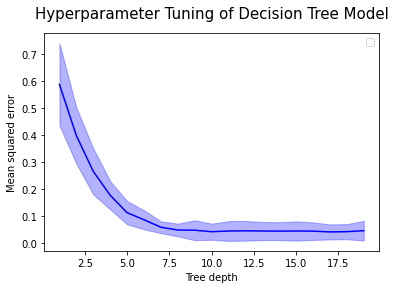

In [44]:
x=df_ln.drop(["PDAS_ln","Mat_HB_ln","Alloy"],axis=1)
y=df_ln[["PDAS_ln"]]
max_depths = range(1, 20)
error = []
error_std = []
num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth)
    cv_result_KF=cross_validate(model_1,x,y,cv=kf,return_estimator=True)
    scores= cross_val_score(model_1, x, y, cv=kf, scoring='neg_mean_squared_error')
    error.append(np.mean(np.abs(scores)))
    error_std.append(np.std(np.abs(scores)))

plt.plot(max_depths, error, color='blue')
plt.fill_between(max_depths, np.array(error)-np.array(error_std), np.array(error)+np.array(error_std),alpha=0.3, color="blue")
                          
                          
#plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')

plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of Decision Tree Model', pad=15, size=15)
plt.legend()



This shows the optimum desition tree branching is 10

## optimizing number of neighbor in KNeighborsRegressor

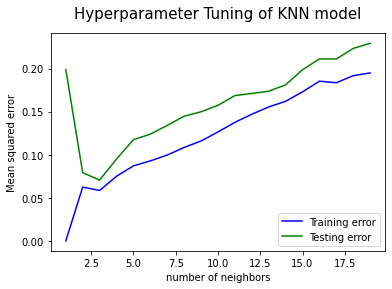

In [45]:
max_neighbors = range(1, 20)
training_error = []
testing_error = []
for i in max_neighbors:
    model_2 = KNeighborsRegressor(n_neighbors=i)
    model_2.fit(x_train, y_train)
    training_error.append(mean_squared_error(y_train, model_2.predict(x_train)))
    testing_error.append(mean_squared_error(y_test, model_2.predict(x_test)))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('number of neighbors')

plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of KNN model', pad=15, size=15)
plt.legend()

## optimizing number of neighbor in KNeighborsRegressor with cross validation

No handles with labels found to put in legend.


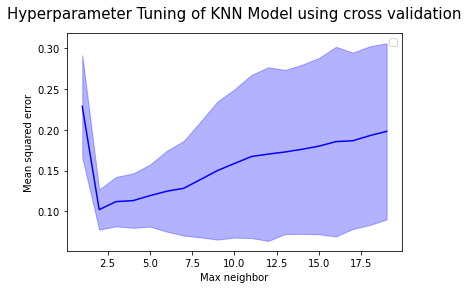

In [46]:
x=df_ln.drop(["PDAS_ln","Mat_HB_ln","Alloy"],axis=1)
y=df_ln[["PDAS_ln"]]
max_neighbors = range(1, 20)
error = []
error_std = []
num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
for i in max_neighbors:
    model_2 = KNeighborsRegressor(n_neighbors=i)
    cv_result_KF=cross_validate(model_2,x,y,cv=kf,return_estimator=True)
    scores= cross_val_score(model_2, x, y, cv=kf, scoring='neg_mean_squared_error')
    error.append(np.mean(np.abs(scores)))
    error_std.append(np.std(np.abs(scores)))

plt.plot(max_neighbors, error, color='blue')
plt.fill_between(max_neighbors, np.array(error)-np.array(error_std), np.array(error)+np.array(error_std),alpha=0.3, color="blue")
                          
                          
#plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Max neighbor')

plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of KNN Model using cross validation', pad=15, size=15)
plt.legend()

This shows the optimize value of neighbors is 2

## Optimizing multiple parameters in Random Forest 

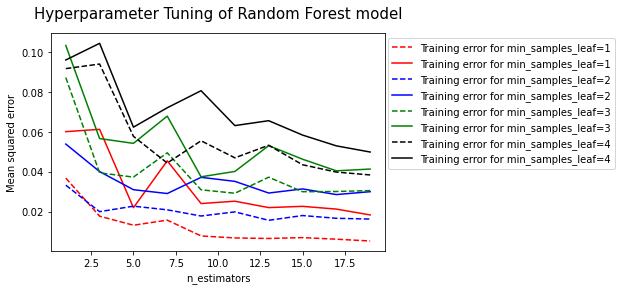

In [47]:
min_samples_leaf = range(1, 5)
n_estimators = range(1, 21,2)

colors=["r","b","g","k","c"]
k=0
for i in min_samples_leaf:
    training_error = []
    testing_error = []
    for j in n_estimators:
        model_3 = RandomForestRegressor(n_estimators=j,min_samples_leaf=i)
        model_3.fit(x_train, y_train.values.ravel())
        training_error.append(mean_squared_error(y_train, model_3.predict(x_train)))
        testing_error.append(mean_squared_error(y_test, model_3.predict(x_test)))
    label_train='Training error for min_samples_leaf={}'.format(i)
    label_test='Training error for min_samples_leaf={}'.format(i)
    plt.plot(n_estimators, training_error, color=colors[k], linestyle="dashed" , label=label_train)
    plt.plot(n_estimators, testing_error, color=colors[k], label=label_test)
    plt.xlabel('n_estimators')
    plt.ylabel('Mean squared error')
    plt.title('Hyperparameter Tuning of Random Forest model', pad=15, size=15)
    plt.legend(bbox_to_anchor=(1.7 , 1), loc="upper right")
    k+=1
plt.show()

In [48]:
x=df_ln.drop(["PDAS_ln","Mat_HB_ln","Alloy"],axis=1)
y=df_ln[["PDAS_ln"]]

min_samples_leaf = range(1, 20)
n_estimators = range(1, 30)
max_depth=range(1, 20)
min_samples_split = range(2, 20)
min_samples_leaf = range(2, 20)
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_3 = RandomForestRegressor()

#rf_random = RandomizedSearchCV(estimator = model_3, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2)
rf_random = GridSearchCV( model_3, random_grid, cv = kf)

rf_random.fit(x_train,y_train.values.ravel()
cv_result_KF=cross_validate(rf_random,x,y,cv=kf,return_estimator=True)
scores= cross_val_score(rf_random, x, y.values.ravel(), cv=kf, scoring='neg_mean_squared_error')


SyntaxError: invalid syntax (Temp/ipykernel_5880/1850481190.py, line 24)

In [49]:
print(rf_random.best_params_)

NameError: name 'rf_random' is not defined

In [50]:
#Now use the best Model parameters to estimate Model accuracy
model_3 = RandomForestRegressor(n_estimators= 16,min_samples_split=3,min_samples_leaf= 2,max_depth= 17,bootstrap= True)
model_3.fit(x_train, y_train.values.ravel())

print(" the training dataset error is {}".format(mean_squared_error(y_train, model_3.predict(x_train))))
print(" the testing dataset error is {}".format(mean_squared_error(y_test, model_3.predict(x_test))))


 the training dataset error is 0.015003138707209977
 the testing dataset error is 0.030336047346932286


## Optimizing Alpha in Ridge Model

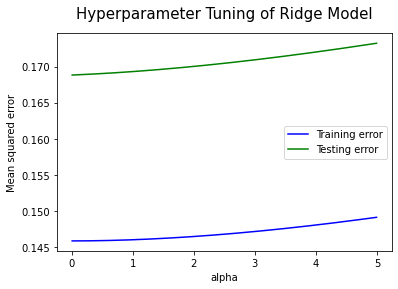

In [51]:
alphas =np.arange(0.01,5,0.01)
training_error = []
testing_error = []
for i in alphas:
#    print(i)
    model_4 = linear_model.Ridge(alpha=i)
    model_4.fit(x_train, y_train)
    training_error.append(mean_squared_error(y_train, model_4.predict(x_train)))
    testing_error.append(mean_squared_error(y_test, model_4.predict(x_test)))

plt.plot(alphas, training_error, color='blue', label='Training error')
plt.plot(alphas, testing_error, color='green', label='Testing error')
plt.xlabel('alpha')

plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of Ridge Model', pad=15, size=15)
plt.legend()

## Optimize Alpha in Ridge Rigression Model with Cross Validation 

No handles with labels found to put in legend.


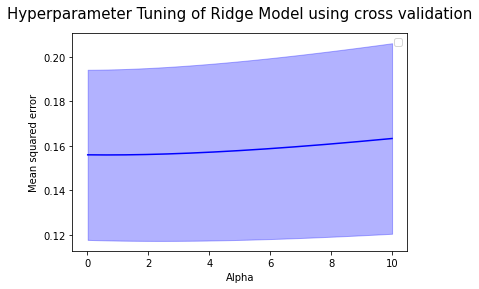

In [52]:
x=df_ln.drop(["PDAS_ln","Mat_HB_ln","Alloy"],axis=1)
y=df_ln[["PDAS_ln"]]
alphas = np.arange(0.01,10,0.01)
error = []
error_std = []
num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
for i in alphas:
    model_4 = linear_model.Ridge(alpha=i)
    cv_result_KF=cross_validate(model_4,x,y,cv=kf,return_estimator=True)
    scores= cross_val_score(model_4, x, y, cv=kf, scoring='neg_mean_squared_error')
    error.append(np.mean(np.abs(scores)))
    error_std.append(np.std(np.abs(scores)))

plt.plot(alphas, error, color='blue')
plt.fill_between(alphas, np.array(error)-np.array(error_std), np.array(error)+np.array(error_std),alpha=0.3, color="blue")
                          
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of Ridge Model using cross validation', pad=15, size=15)
plt.legend()

In [53]:
index_min=error.index(min(error))
alpha_min=alphas[index_min]
print("The Alpha resulting minimum error is {} and the correspondig error is {}".format(alpha_min,error[index_min]))

The Alpha resulting minimum error is 0.65 and the correspondig error is 0.1559206088009987


## Optimum Ridge Model Parameters via Cross Validation

In [54]:
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_4 = linear_model.Ridge(alpha=alpha_min,fit_intercept=True)
cv_result_KF=cross_validate(model_4,x,y,cv=kf,return_estimator=True)
scores= cross_val_score(model_4, x, y, cv=kf, scoring='neg_mean_squared_error')
coeff=np.zeros((num_split,4))
i=0
for model in cv_result_KF['estimator']:
    coeff[i,0]=model.intercept_[0]
    coeff[i,1]=model.coef_[0,0]
    coeff[i,2]=model.coef_[0,1]
    coeff[i,3]=model.coef_[0,2]

    i+=1
    
#print(coeff)
print("the mean ln(intercept) is {}+/-{}".format(np.mean(coeff[:,0]),np.std(coeff[:,0])))
print("the mean LN(V) coefficients is {}+/-{}".format(np.mean(coeff[:,1]),np.std(coeff[:,1])))
print("the mean ln(G) coefficients is {}+/-{}".format(np.mean(coeff[:,2]),np.std(coeff[:,2])))
print("the mean ln(matprop) coefficients is {}+/-{}".format(np.mean(coeff[:,3]),np.std(coeff[:,3])))


#Ridge_coeff=cv_result_KF["estimator"].coeff_

the mean ln(intercept) is 15.57874710938305+/-0.29799071105407754
the mean LN(V) coefficients is -0.7180157312966496+/-0.006578542301849984
the mean ln(G) coefficients is -0.8204944303683149+/-0.011669191473821899
the mean ln(matprop) coefficients is 0.6492025560368696+/-0.007323740496856209


## Optimize Alpha in Lasso Rigression Model with Cross Validation 

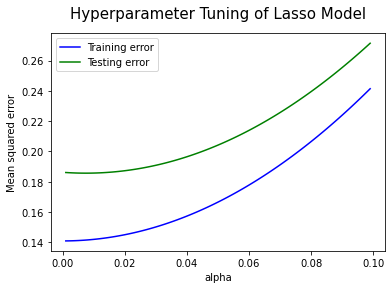

In [55]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)
alphas =np.arange(0.001,0.1,0.001)
training_error = []
testing_error = []
for i in alphas:
#    print(i)
    model_5 = linear_model.Lasso(alpha=i)
    model_5.fit(x_train, y_train)
    training_error.append(mean_squared_error(y_train, model_5.predict(x_train)))
    testing_error.append(mean_squared_error(y_test, model_5.predict(x_test)))

plt.plot(alphas, training_error, color='blue', label='Training error')
plt.plot(alphas, testing_error, color='green', label='Testing error')
plt.xlabel('alpha')

plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of Lasso Model', pad=15, size=15)
plt.legend()

In [56]:
## Optimize Alpha in Lasso Rigression Model Based using Cross Validation

No handles with labels found to put in legend.


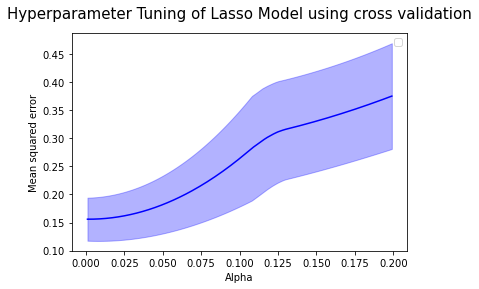

In [57]:
x=df_ln.drop(["PDAS_ln","Mat_HB_ln","Alloy"],axis=1)
y=df_ln[["PDAS_ln"]]
alphas = np.arange(0.001,0.2,0.001)
error = []
error_std = []
num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
for i in alphas:
    model_5 = linear_model.Lasso(alpha=i)
    cv_result_KF=cross_validate(model_5,x,y,cv=kf,return_estimator=True)
    scores= cross_val_score(model_5, x, y, cv=kf, scoring='neg_mean_squared_error')
    error.append(np.mean(np.abs(scores)))
    error_std.append(np.std(np.abs(scores)))

plt.plot(alphas, error, color='blue')
plt.fill_between(alphas, np.array(error)-np.array(error_std), np.array(error)+np.array(error_std),alpha=0.3, color="blue")
                          
plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of Lasso Model using cross validation', pad=15, size=15)
plt.legend()

In [58]:
index_min_lasso=error.index(min(error))
alpha_min_lasso=alphas[index_min_lasso]
print("The Alpha resulting minimum error for Lasso Rigression Model is {} and the correspondig error is {}".format(alpha_min_lasso,error[index_min_lasso]))

The Alpha resulting minimum error for Lasso Rigression Model is 0.002 and the correspondig error is 0.15593626359413804


## All Optimized Model's Performance

In [59]:
##Randomforest
model_RF = RandomForestRegressor(n_estimators= 16,min_samples_split=3,min_samples_leaf= 2,max_depth= 17,bootstrap= True)
model_RF.fit(x_train, y_train.values.ravel())
# Prediction
y_pred_RF = model_RF.predict(x_test)
print("mean squared error of Random Forest Regressor for testing data is ", mean_squared_error(y_test,y_pred_RF))

##GradientBoostingRegressor
#model_XGB = GradientBoostingRegressor()
#model_XGB.fit(x_train, y_train)

# Prediction
#y_pred_XGB = model_XGB.predict(x_test)
#print("mean squared error of Gradient Boosting Regressor for testing data is ", mean_squared_error(y_test,y_pred_XGB))



##DecisionTreeRegressor()
model_DTR = DecisionTreeRegressor(max_depth=10)
model_DTR.fit(x_train, y_train)

# Prediction
y_pred_DTR = model_DTR.predict(x_test)
print("mean squared error of Decision Tree Regressorr for testing data is ", mean_squared_error(y_test,y_pred_DTR))

##KNN()
model_KNN = KNeighborsRegressor(n_neighbors=2)
model_KNN.fit(x_train, y_train)

# Prediction
y_pred_KNN = model_KNN.predict(x_test)
print("mean squared error of K Neighbors Regressor for testing data is ", mean_squared_error(y_test,y_pred_KNN))


##SVR()
#model_SVR = SVR()
#model_SVR.fit(x_train, y_train)

# Prediction
#y_pred_SVR = model_SVR.predict(x_test)
#print("mean squared error of SVR for testing data is ", mean_squared_error(y_test,y_pred_SVR))


##PassiveAggressiveRegressor()
#model_PAC = linear_model.PassiveAggressiveRegressor()
#model_PAC.fit(x_train, y_train)

# Prediction
#y_pred_PAC = model_PAC.predict(x_test)
#print("mean squared error of Passive Aggressive Regressorrf_random for testing data is ", mean_squared_error(y_test,y_pred_PAC))
        
##Ridge()
model_Ridge = linear_model.Ridge(alpha=alpha_min)
model_Ridge.fit(x_train, y_train)

# Prediction
y_pred_Ridge = model_Ridge.predict(x_test)
print("mean squared error of Ridge for testing data is ", mean_squared_error(y_test,y_pred_Ridge))
        
model_Lasso = linear_model.Lasso(alpha=alpha_min_lasso)
model_Lasso.fit(x_train, y_train)

# Prediction
y_pred_Lasso = model_Lasso.predict(x_test)
print("mean squared error of Lasso for testing data is ", mean_squared_error(y_test,y_pred_Lasso))   


#Linear regression
Model_LR= linear_model.LinearRegression()
Model_LR.fit(x_train, y_train)
y_pred_LR = model_Ridge.predict(x_test)
print("mean squared error of Ridge for experimental data is ", mean_squared_error(y_test,y_pred_LR))

mean squared error of Random Forest Regressor for testing data is  0.033825105807287315
mean squared error of Decision Tree Regressorr for testing data is  0.032820648707709614
mean squared error of K Neighbors Regressor for testing data is  0.11450023303612593
mean squared error of Ridge for testing data is  0.1857563564383961
mean squared error of Lasso for testing data is  0.18598562607590743
mean squared error of Ridge for experimental data is  0.1857563564383961


Text(0.5, 0.98, 'ML Models Based on KF Material Properties Predicting computational Data')

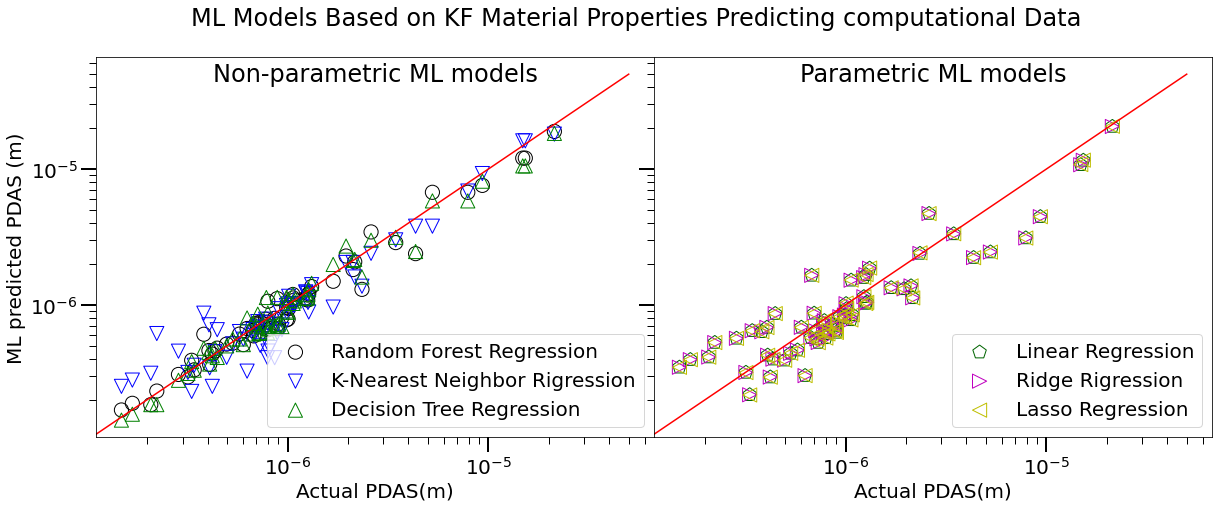

In [60]:
fig=plt.figure(figsize=(20,7))
plt.rc('font', size=20)
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
(axs1, axs2) = gs.subplots(sharey='row')
axs1.scatter(np.exp(y_test), np.exp(y_pred_RF), marker="o", s=200, facecolors='none', edgecolors='k', label="Random Forest Regression")
axs1.scatter(np.exp(y_test), np.exp(y_pred_KNN), marker="v", s=200, facecolors='none', edgecolors='b', label="K-Nearest Neighbor Rigression")
axs1.scatter(np.exp(y_test), np.exp(y_pred_DTR), marker="^", s=200, facecolors='none', edgecolors='g', label="Decision Tree Regression")
axs1.plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axs1.set_xscale("log")
axs1.set_yscale("log")
axs1.legend(loc="lower right",frameon=True) #,
axs1.set_xlabel("Actual PDAS(m)")
axs1.set_ylabel("ML predicted PDAS (m)")
axs1.tick_params('both', length=15, width=2, which='major')
axs1.tick_params('both', length=7, width=1, which='minor')
axs1.set_title("Non-parametric ML models",y=0.92)


axs2.scatter(np.exp(y_test), np.exp(y_pred_LR), marker="p", s=200, facecolors='none', edgecolors='darkgreen', label="Linear Regression")
axs2.scatter(np.exp(y_test), np.exp(y_pred_Ridge), marker=">", s=200, facecolors='none', edgecolors='m', label="Ridge Rigression")
axs2.scatter(np.exp(y_test), np.exp(y_pred_Lasso), marker="<", s=200, facecolors='none', edgecolors='y', label="Lasso Regression")
axs2.plot([0,5e-5],[0,5e-5],marker="None",color="red")
axs2.tick_params('both', length=15, width=2, which='major')
axs2.tick_params('both', length=7, width=1, which='minor')
axs2.set_xlabel("Actual PDAS(m)")
axs2.set_xscale("log")
axs2.set_yscale("log")
axs2.legend(loc="lower right",frameon=True) #,frameon=False
axs2.set_title("Parametric ML models",y=0.92)
fig.suptitle("ML Models Based on KF Material Properties Predicting computational Data")

In [61]:
df_exp["PDAS_ln"]=np.log(df_exp["PDAS"])
df_exp["V_ln"]=np.log(df_exp["V"])
df_exp["G_ln"]=np.log(df_exp["G"])
df_exp["Mat_HB_ln"]=np.log(df_exp["Mat_HB"])
df_exp["Mat_KF_ln"]=np.log(df_exp["Mat_KF"])
df_exp_ln=df_exp.drop(["PDAS","V","G","Mat_HB","Mat_KF"],axis=1)


In [62]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   V          26 non-null     float64
 1   G          26 non-null     float64
 2   Mat_HB     26 non-null     float64
 3   Mat_KF     26 non-null     float64
 4   PDAS       26 non-null     float64
 5   Alloy      26 non-null     object 
 6   PDAS_ln    26 non-null     float64
 7   V_ln       26 non-null     float64
 8   G_ln       26 non-null     float64
 9   Mat_HB_ln  26 non-null     float64
 10  Mat_KF_ln  26 non-null     float64
dtypes: float64(10), object(1)
memory usage: 2.4+ KB


In [63]:
df_exp.isna().any()

V            False
G            False
Mat_HB       False
Mat_KF       False
PDAS         False
Alloy        False
PDAS_ln      False
V_ln         False
G_ln         False
Mat_HB_ln    False
Mat_KF_ln    False
dtype: bool

In [64]:
alloy_exp=df_exp.Alloy.unique()
print(alloy_exp)

['INC718' 'Ti-48 at%Ni' 'SRR99 ']


In [65]:

x=df_ln.drop(["PDAS_ln","Mat_HB_ln", "Alloy"],axis=1)

x=sm.add_constant(x)
y=df[["PDAS_ln"]]

# Split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

x_exp=df_exp_ln.drop(["PDAS_ln","Mat_HB_ln","Alloy"],axis=1)
x_exp=sm.add_constant(x_exp)
y_exp=df_exp_ln[["PDAS_ln"]]

In [68]:
##Randomforest
model_RF = RandomForestRegressor(n_estimators= 16,min_samples_split=3,min_samples_leaf= 2,max_depth= 17,bootstrap= True)
model_RF.fit(x_train, y_train.values.ravel())
# Prediction
y_pred_RF = model_RF.predict(x_exp)
print("mean squared error of Random Forest Regressor for testing data is ", mean_squared_error(y_exp,y_pred_RF))

##GradientBoostingRegressor
model_XGB = GradientBoostingRegressor()
model_XGB.fit(x_train, y_train)

# Prediction
y_pred_XGB = model_XGB.predict(x_exp)
print("mean squared error of Gradient Boosting Regressor for experimental data is ", mean_squared_error(y_exp,y_pred_XGB))



##DecisionTreeRegressor()
model_DTR = DecisionTreeRegressor(max_depth=10)
model_DTR.fit(x_train, y_train)

# Prediction
y_pred_DTR = model_DTR.predict(x_exp)
print("mean squared error of Decision Tree Regressorr for experimental data  is ", mean_squared_error(y_exp,y_pred_DTR))

##KNN()
model_KNN = KNeighborsRegressor(n_neighbors=2)
model_KNN.fit(x_train, y_train)

# Prediction
y_pred_KNN = model_KNN.predict(x_exp)
print("mean squared error of K Neighbors Regressor for experimental data  is ", mean_squared_error(y_exp,y_pred_KNN))


##SVR()
model_SVR = SVR()
model_SVR.fit(x_train, y_train)

# Prediction
y_pred_SVR = model_SVR.predict(x_exp)
print("mean squared error of SVR for experimental data is ", mean_squared_error(y_exp,y_pred_SVR))


##assiveAggressiveRegressor()
model_PAC = linear_model.PassiveAggressiveRegressor()
model_PAC.fit(x_train, y_train)

# Prediction
y_pred_PAC = model_PAC.predict(x_exp)
print("mean squared error of Passive Aggressive Regressorrf_random for experimental data is ", mean_squared_error(y_exp,y_pred_PAC))
        
##Ridge()
model_Ridge = linear_model.Ridge(alpha=alpha_min)
model_Ridge.fit(x_train, y_train)

# Prediction
y_pred_Ridge = model_Ridge.predict(x_exp)
print("mean squared error of Ridge for experimental data is ", mean_squared_error(y_exp,y_pred_Ridge))

##Lasso()
model_Lasso = linear_model.Lasso(alpha=alpha_min_lasso)
model_Lasso.fit(x_train, y_train)

# Prediction
y_pred_Lasso = model_Lasso.predict(x_exp)
print("mean squared error of Lasso for experimental data is ", mean_squared_error(y_exp,y_pred_Lasso))

#Linear regression
Model_LR= linear_model.LinearRegression()
Model_LR.fit(x_train, y_train)
y_pred_LR = model_Ridge.predict(x_exp)
print("mean squared error of Ridge for experimental data is ", mean_squared_error(y_exp,y_pred_LR))
 

mean squared error of Random Forest Regressor for testing data is  2.1487473901704766
mean squared error of Gradient Boosting Regressor for experimental data is  2.4379374033995016
mean squared error of Decision Tree Regressorr for experimental data  is  1.6863719974010325
mean squared error of K Neighbors Regressor for experimental data  is  1.6230268238622185
mean squared error of SVR for experimental data is  4.948036120569985


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


mean squared error of Passive Aggressive Regressorrf_random for experimental data is  1.8572584565722545
mean squared error of Ridge for experimental data is  0.23939059252607142
mean squared error of Lasso for experimental data is  0.231689056727176
mean squared error of Ridge for experimental data is  0.23939059252607142


Text(0.5, 0.98, 'ML Models Based on KF Material Properties Predicting Experimental Data')

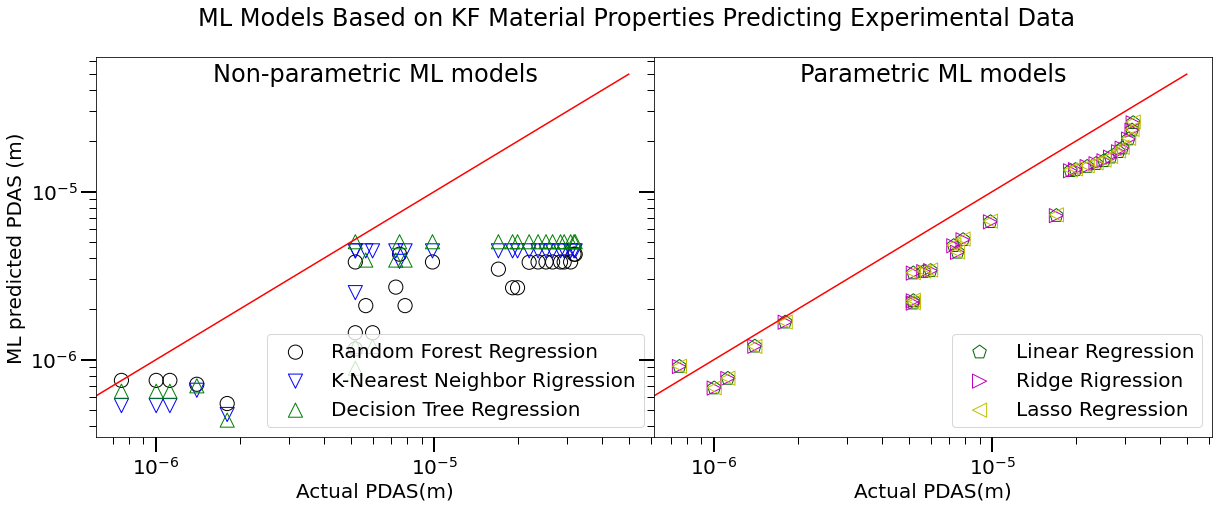

In [67]:
fig=plt.figure(figsize=(20,7))
plt.rc('font', size=20)
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
(axs1, axs2) = gs.subplots(sharey='row')
axs1.scatter(np.exp(y_exp), np.exp(y_pred_RF), marker="o", s=200, facecolors='none', edgecolors='k', label="Random Forest Regression")
axs1.scatter(np.exp(y_exp), np.exp(y_pred_KNN), marker="v", s=200, facecolors='none', edgecolors='b', label="K-Nearest Neighbor Rigression")
axs1.scatter(np.exp(y_exp), np.exp(y_pred_DTR), marker="^", s=200, facecolors='none', edgecolors='g', label="Decision Tree Regression")
axs1.plot([0,5e-5],[0,5e-5],marker="None",color="red")
#axs1.set_xlim([1e-7,1e-4])
#axs1.set_ylim([1e-7,1e-4])
axs1.set_xscale("log")
axs1.set_yscale("log")
axs1.legend(loc="lower right",frameon=True)
axs1.set_xlabel("Actual PDAS(m)")
axs1.set_ylabel("ML predicted PDAS (m)")
axs1.tick_params('both', length=15, width=2, which='major')
axs1.tick_params('both', length=7, width=1, which='minor')
axs1.set_title("Non-parametric ML models",y=0.92)


axs2.scatter(np.exp(y_exp), np.exp(y_pred_LR), marker="p", s=200, facecolors='none', edgecolors='darkgreen', label="Linear Regression")
axs2.scatter(np.exp(y_exp), np.exp(y_pred_Ridge), marker=">", s=200, facecolors='none', edgecolors='m', label="Ridge Rigression")
axs2.scatter(np.exp(y_exp), np.exp(y_pred_Lasso), marker="<", s=200, facecolors='none', edgecolors='y', label="Lasso Regression")
axs2.plot([0,5e-5],[0,5e-5],marker="None",color="red")
axs2.tick_params('both', length=15, width=2, which='major')
axs2.tick_params('both', length=7, width=1, which='minor')
axs2.set_xlabel("Actual PDAS(m)")
axs2.set_xscale("log")
axs2.set_yscale("log")
axs2.legend(loc="lower right",frameon=True)
axs2.set_title("Parametric ML models",y=0.92)
fig.suptitle("ML Models Based on KF Material Properties Predicting Experimental Data")

### Conclusions

1- We obtain a very important conclusion that in contract to analytical models, where temperature gradient plays much important role in the PDAS estimations, the velocity and temperature play almost equal roles in PDAS correlation!

2- In addition we compared different parametric and non parametric models. Despite the better performance of paranetric models 
on the computational data, when we compared them with the experimental predictions, they presented a much poorer performance and therefore, the parametric linear regression models works the best.

3- As we observed by the cross validation, the optimized alpha values for Ridge and Lasso regression models were very small. Therefore, we were already expecting the predictions of linear regression be close to Ridge and lasso models. As expected, the prediction of these models are very close to each other both for the experiment and computational data!